#### Error Model Testing

Start by importing all dependencies and set some RNG seeds for reproducibility

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.callbacks import TensorBoard

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger

import numpy as np
import tensorflow as tf

from deepq.Function_Library import *
from deepq.Environments import *

import pickle
import sys
import os
import datetime
import random
import pprint

# ---------------------------------------------------------------------------------------------

RANDOM_SEED = 0
os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

Load model configs from trained model folder

In [8]:
def load_agent_config(trained_model_dir: str, config: str, error_rate: str):
    fixed_configs_path = os.path.join(trained_model_dir, "fixed_config.p")
    variable_configs_path = os.path.join(
        trained_model_dir, error_rate, f"variable_config_{config}.p")
    model_weights_path = os.path.join(
        trained_model_dir, error_rate, "final_dqn_weights.h5f")

    fixed_configs = pickle.load(open(fixed_configs_path, "rb"))
    variable_configs = pickle.load(open(variable_configs_path, "rb"))

    all_configs = {}
    for key in fixed_configs.keys():
        all_configs[key] = fixed_configs[key]
    for key in variable_configs.keys():
        all_configs[key] = variable_configs[key]
    all_configs["model_weights_path"] = model_weights_path
    return all_configs

trained_model_dir = "../trained_models/d5_dp_mwpm"  # path to trained model configs
error_rate = "0.007"  # error rate at which model was trained
config = "117"  # incumbent config number

all_configs = load_agent_config(trained_model_dir, config, error_rate)
pprint.pprint(all_configs)

{'batch_size': 32,
 'buffer_size': 50000,
 'c_layers': [[64, 3, 2], [32, 2, 1], [32, 2, 1]],
 'd': 5,
 'dueling': True,
 'error_model': 'DP',
 'exploration_fraction': 100000,
 'ff_layers': [[512, 0.2]],
 'final_eps': 0.001,
 'gamma': 0.99,
 'learning_rate': 5e-06,
 'learning_starts': 1000,
 'masked_greedy': False,
 'max_eps': 0.5,
 'max_timesteps': 1000000,
 'model_weights_path': '../trained_models/d5_dp_mwpm/0.007/final_dqn_weights.h5f',
 'p_meas': 0.007,
 'p_phys': 0.007,
 'print_freq': 250,
 'rolling_average_length': 1000,
 'static_decoder': False,
 'stopping_patience': 1000,
 'success_threshold': 100000,
 'target_network_update_freq': 2500,
 'testing_length': 101,
 'train_freq': 1,
 'use_Y': False,
 'volume_depth': 5}


In [10]:
def build_agent_model(all_configs, env):
    model = build_convolutional_nn(
        all_configs["c_layers"],
        all_configs["ff_layers"],
        env.observation_space.shape,
        env.num_actions,
    )
    memory = SequentialMemory(
        limit=all_configs["buffer_size"], window_length=1)
    policy = GreedyQPolicy(masked_greedy=True)
    test_policy = GreedyQPolicy(masked_greedy=True)

    dqn = DQNAgent(
        model=model,
        nb_actions=env.num_actions,
        memory=memory,
        nb_steps_warmup=all_configs["learning_starts"],
        target_model_update=all_configs["target_network_update_freq"],
        policy=policy,
        test_policy=test_policy,
        gamma=all_configs["gamma"],
        enable_dueling_network=all_configs["dueling"],
    )

    dqn.compile(Adam(lr=all_configs["learning_rate"]))
    dqn.model.load_weights(all_configs["model_weights_path"])
    return dqn

# --- Build env ---------------------------------------------------------------------------------

env = Surface_Code_Environment_Multi_Decoding_Cycles(
    d=all_configs["d"],
    p_phys=all_configs["p_phys"],
    p_meas=all_configs["p_meas"],
    error_model=all_configs["error_model"],
    use_Y=all_configs["use_Y"],
    volume_depth=all_configs["volume_depth"],
    static_decoder=None,
)

# --- Build model --------------------------------------------------------------------------------

dqn = build_agent_model(all_configs, env)

In [11]:
# --- Model evaluation ---------------------------------------------------------------------------

trained_at = all_configs["p_phys"]
num_to_test = 20
error_rates = [j*0.001 for j in range(1, num_to_test + 1)]
thresholds = [1/p for p in error_rates]
nb_test_episodes = all_configs["testing_length"]
all_results = {}


keep_evaluating = True
count = 0
while keep_evaluating:
    err_rate = error_rates[count]
    env.p_phys = err_rate
    env.p_meas = err_rate

    dict_key = str(err_rate)[:5]

    testing_history = dqn.test(env, nb_episodes=nb_test_episodes,
                             visualize=False, verbose=2, interval=10, single_cycle=False)
    results = testing_history.history["episode_lifetimes_rolling_avg"]
    final_result = results[-1:][0]
    all_results[dict_key] = final_result

    if abs(trained_at - err_rate) < 1e-6:
    results_file = os.path.join(variable_configs_folder, "results.p")
#     pickle.dump(results, open(results_file, "wb"))

    to_beat = thresholds[count]
    if final_result < to_beat or count == (num_to_test - 1):
    keep_evaluating = False

    count += 1

all_results_file = os.path.join(variable_configs_folder, "all_results.p")
# pickle.dump(all_results, open(all_results_file, "wb"))

Testing for 101 episodes ...



KeyboardInterrupt: 

#### Results

We begin by showing the results of full evaluations. In particular, we start by importing all necessary packages:

In [10]:
import os
import matplotlib as mpl
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pickle
import json
from cycler import cycler

rcparams = {                      
    "pgf.texsystem": "pdflatex",        
    "text.usetex": True,               
    "font.family": "Latin Modern Roman",
    "font.serif": [],                   
    "font.sans-serif": [],
    "font.monospace": [],          
    "font.size": 12,
    "legend.fontsize": 12,         
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    
        r"\usepackage[T1]{fontenc}",        
        ]
}
mpl.rcParams.update(rcparams)

We now need to define some helper functions to allow us to extract the results:

In [11]:
cwd = os.getcwd()
ordered_keys = ["0.001","0.002","0.003","0.004","0.005","0.006","0.007","0.008",
                "0.009","0.01","0.011","0.012","0.013", "0.014","0.015"]
variable_keys = ["exploration_fraction", "max_eps", "final_eps", "learning_rate", "target_network_update_freq"]

def dict_to_list(the_dict, ordered_keys):
    output_list = []
    for key in ordered_keys:
        if key in the_dict.keys():
            output_list.append(the_dict[key])
    return output_list

def config_dict_to_string(config_dict, variable_keys):
    base_string = "["
    end = len(variable_keys)
    count = 1
    for key in variable_keys:
        if key in config_dict.keys():
            if count < end:
                if key == "exploration_fraction":
                    if config_dict[key] == 100000:
                        base_string = base_string+"1e5, "
                    else:
                        base_string = base_string+"2e5, "
                else:
                    base_string = base_string+str(config_dict[key])+", "
            else:
                base_string = base_string+str(config_dict[key])+"]"
            count +=1
    return base_string

def get_ordered_results(folder: str) -> dict:
    results_dict = {}
    training_dict = {}
    configs_dict = {}
    
    for direct in os.listdir(folder):
        if "fixed_config" not in direct:
            path_to_results = os.path.join(folder,direct+"/all_results.p")
            path_to_training_history = os.path.join(folder,direct+"/training_history.json")
            # contains average qubit lifetimes of decoder trained at one error rate and evaluated against stepwise increasing noise
            results_dict[direct] = pickle.load( open(path_to_results, "rb" ))
            with open(path_to_training_history) as f:
                history = json.load(f)
            training_dict[direct] = history["episode_lifetimes_rolling_avg"]

            err_direct = os.path.join(folder,direct)
            for f in os.listdir(err_direct):
                if "variable_config" in f:
                    path_to_config = os.path.join(err_direct,f)
            configs_dict[direct] = config_dict_to_string(pickle.load( open(path_to_config, "rb" )),variable_keys)

    ordered_results = {}

    for key in results_dict.keys():
        ordered_results[key] = dict_to_list(results_dict[key], ordered_keys)
    return ordered_results

def get_best_results(ordered_results: dict) -> list:
    best_results = []
    for j in range(20):
        benchmark = 0
        for agent in ordered_keys:
            if agent in ordered_results.keys():
                if len(ordered_results[agent]) >= j+1:
                    if ordered_results[agent][j] > benchmark:
                        benchmark = ordered_results[agent][j]
        best_results.append(benchmark)
    return best_results

And now we can extract and format the results, both from the bitflip and depolarising noise simulations:

In [12]:
# load results for decoder that we are evaluationg: d5_dp_mwpm
dp_folder = os.path.join(cwd,"../trained_models/d5_dp_mwpm/")
ordered_dp_results = {}

ordered_dp_results = get_ordered_results(dp_folder)

In [13]:
# load results for decoder that serves as baseline: d5_dp
dp_nn_folder = os.path.join(cwd,"../trained_models/d5_dp/")
ordered_dp_nn_results = {}

ordered_dp_nn_results = get_ordered_results(dp_nn_folder)

Finally, we can plot the results:

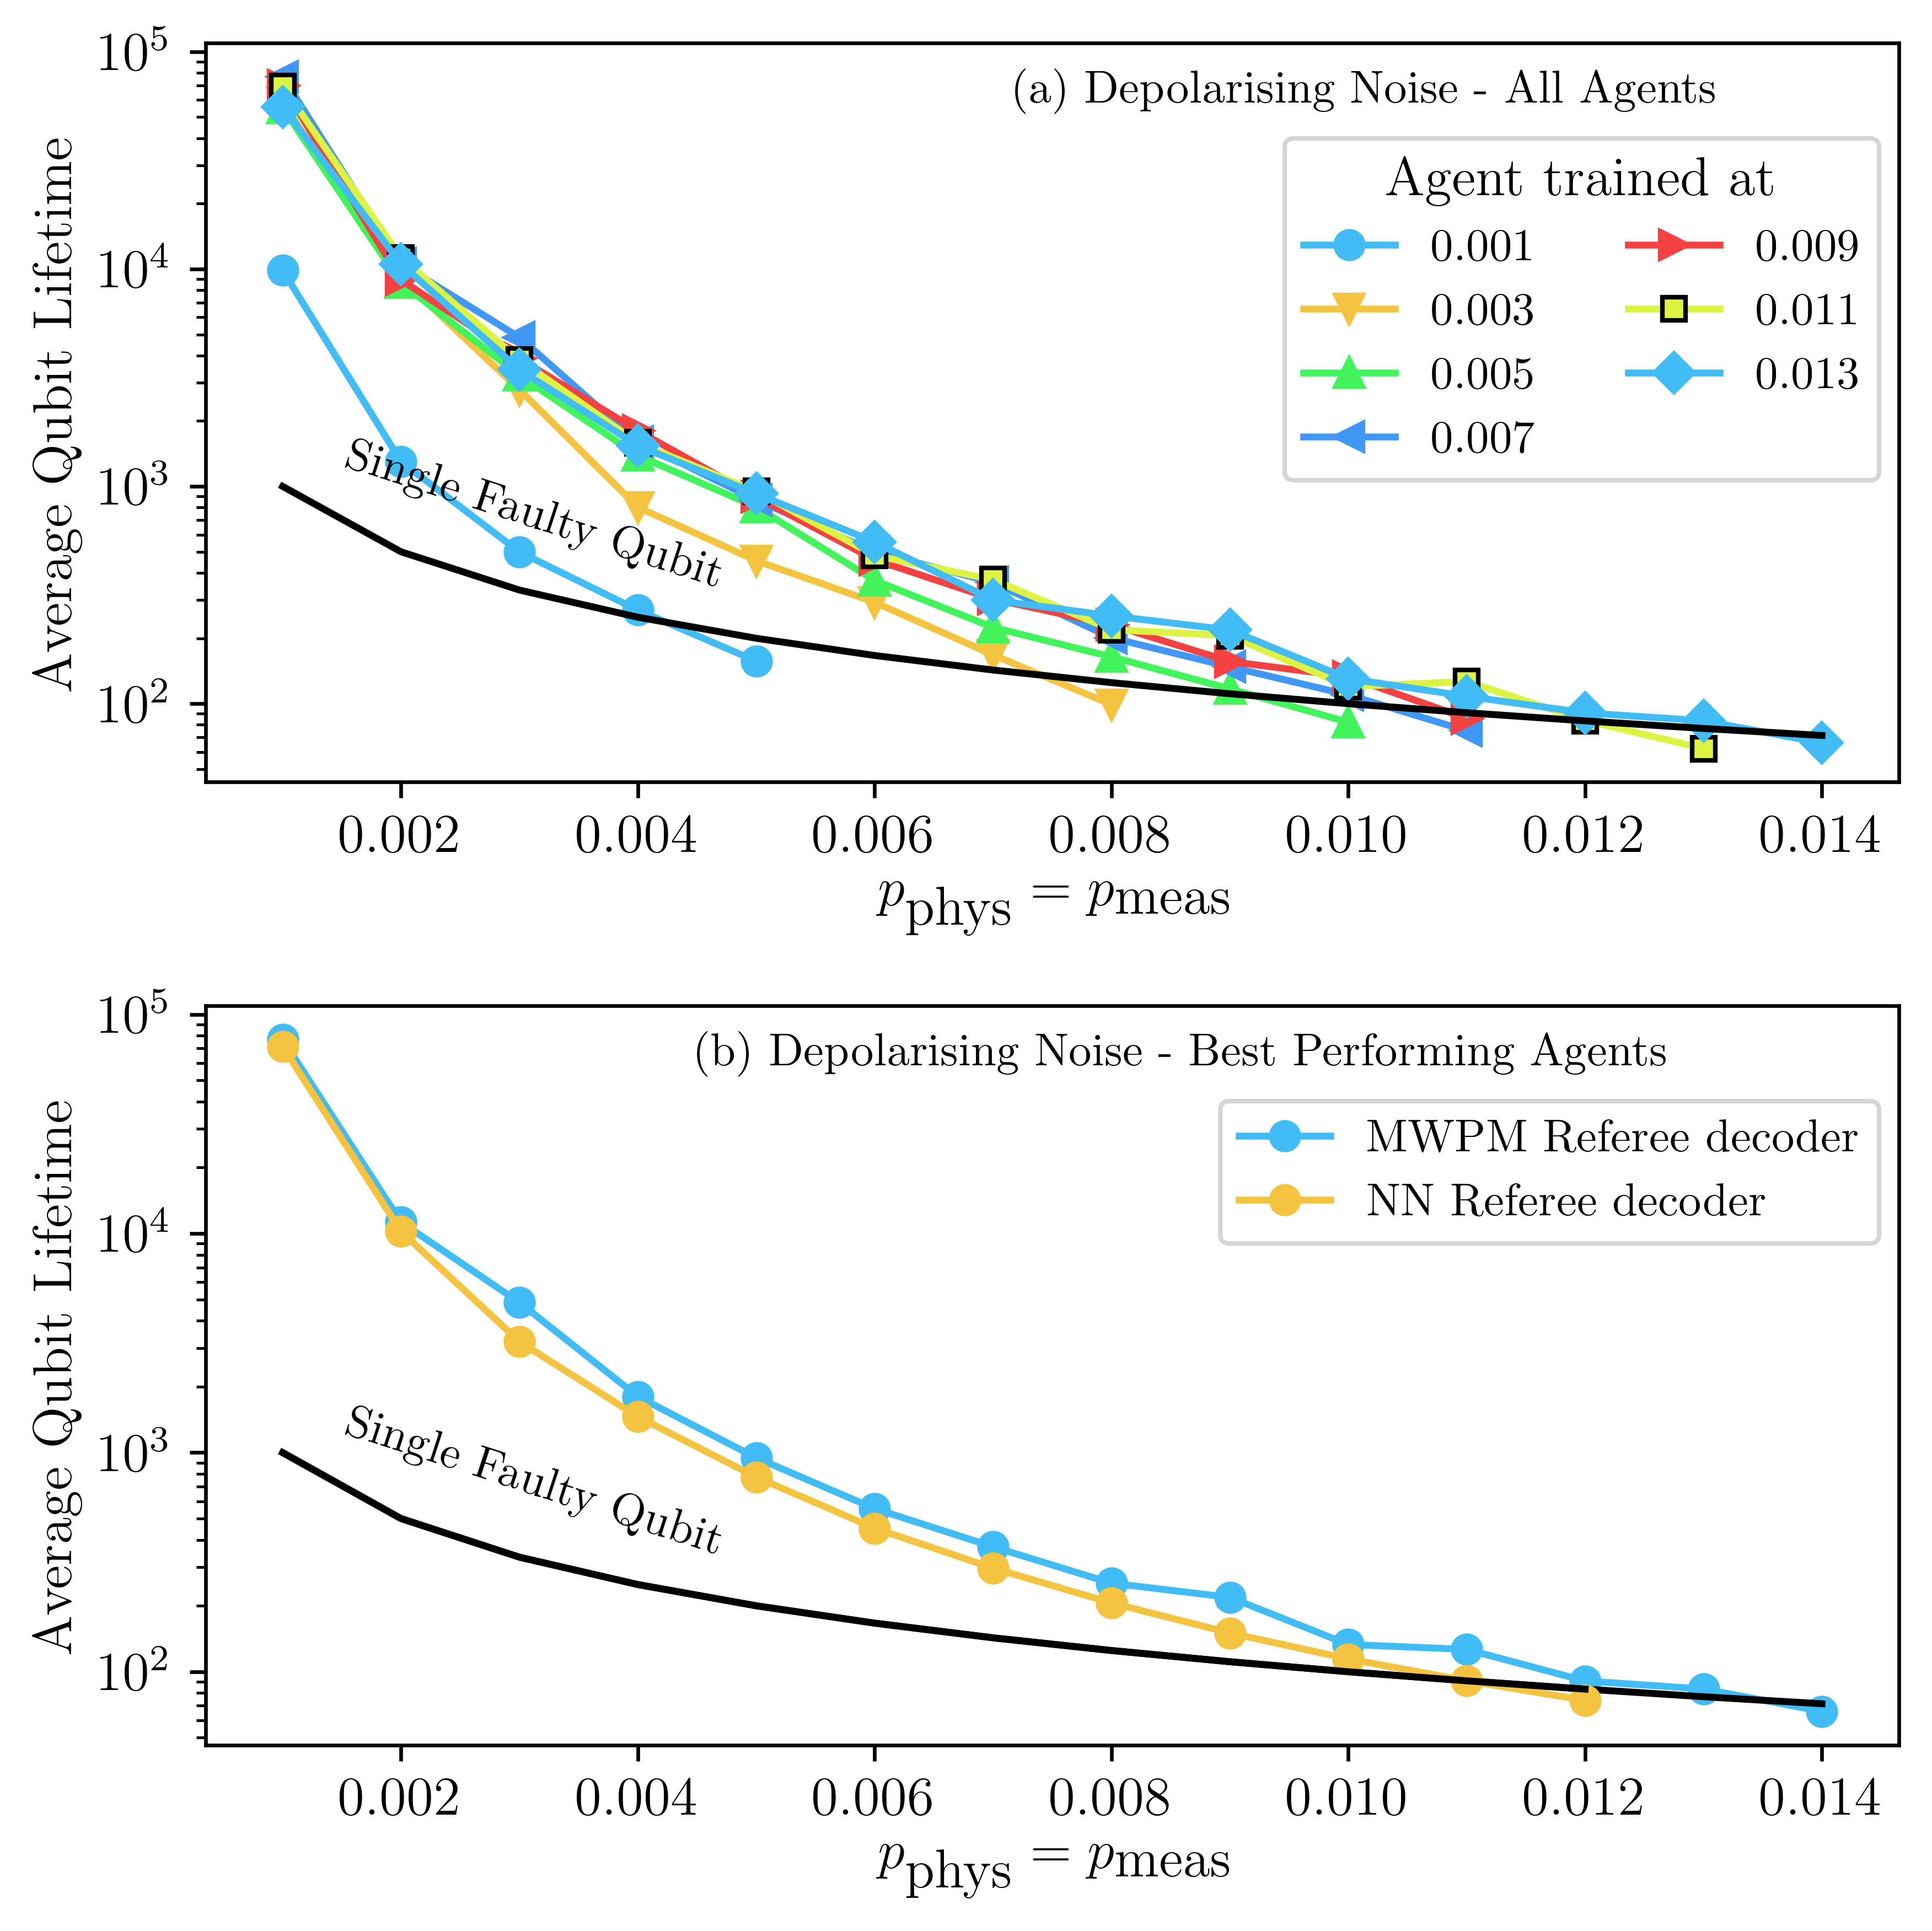

In [14]:
fig, ax = plt.subplots(2,1,dpi=600,figsize=(6,6))

markers = ["o","v","^","<",">","s","D","*"]
p_phys = [j*0.001 for j in range(1,20)]
bench = [1/p for p in p_phys]

custom_colors=["#42bcf4", "#f4c441", "#41f45b", "#4197f4", "#f44141", "#dcf441"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=custom_colors)

#---------------------------------------------------------------------------------
#
# Depolarizing noise - All agents
#
#---------------------------------------------------------------------------------
p_phys = [j*0.001 for j in range(1,20)]
bench = [1/p for p in p_phys]

count = 0
max_l = 0
for key in ordered_keys:
    if key in ordered_dp_results.keys():
        if max_l < len(ordered_dp_results[key]):
            max_l = len(ordered_dp_results[key])
        if( key != "0.011" ):
            #ax.plot(p_phys[:len(ordered_x_results[key])],ordered_x_results[key], marker=markers[count], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$%s$"%key)
            ax[0].plot(p_phys[:len(ordered_dp_results[key])],ordered_dp_results[key], marker=markers[count], markersize=6, label="$%s$"%key)
        else:
            ax[0].plot(p_phys[:len(ordered_dp_results[key])],ordered_dp_results[key], marker=markers[count], markersize=5, markeredgecolor='k', label="$%s$"%key)
        count += 1
                        
ax[0].plot(p_phys[:max_l],bench[:max_l],"k")#,label="Single \n Faulty Qubit")
ax[0].text(0.0015, 340, "Single Faulty Qubit", rotation=-18, fontsize=10)
ax[0].text(0.478, 0.92, "(a) Depolarising Noise - All Agents", fontsize=10,transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].set_ylabel("Average Qubit Lifetime")
ax[0].set_xlabel("$p_{\\textrm{phys}} = p_{\\textrm{meas}}$")
ax[0].legend(fancybox=True, ncol=2, title="Agent trained at",fontsize=10,bbox_to_anchor=(0.002, 0.8, 1., .102))


#---------------------------------------------------------------------------------
#
# Depolarizing noise - Best agents
#
#---------------------------------------------------------------------------------
best_results = get_best_results(ordered_dp_results)
first_zero = best_results.index(0)
best_results = best_results[:first_zero]

best_results_baseline = get_best_results(ordered_dp_nn_results)
first_zero = best_results_baseline.index(0)
best_results_baseline = best_results_baseline[:first_zero]

ax[1].plot(p_phys[:len(best_results)], best_results, '-o', label="MWPM Referee decoder")
ax[1].plot(p_phys[:len(best_results)],bench[:len(best_results)],"k")
ax[1].set_yscale('log')

ax[1].plot(p_phys[:len(best_results_baseline)], best_results_baseline, '-o', label="NN Referee decoder")
ax[1].plot(p_phys[:len(best_results_baseline)],bench[:len(best_results_baseline)],"k")
ax[1].set_yscale('log')

ax[1].text(0.0015, 340, "Single Faulty Qubit", rotation=-18, fontsize=10)
ax[1].text(0.29, 0.92, "(b) Depolarising Noise - Best Performing Agents", fontsize=10,transform=ax[1].transAxes)
    
ax[1].set_ylabel("Average Qubit Lifetime")
ax[1].set_xlabel("$p_{\\textrm{phys}} = p_{\\textrm{meas}}$")
ax[1].legend(fancybox=True,fontsize=10,bbox_to_anchor=(0.002, 0.8, 1., .102))

fig.tight_layout()
#fig.savefig("./Images/final_results.pdf", bbox_inches='tight')